In [1]:
from pystac_client import Client
import planetary_computer as pc

STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_URL)
catalog


<Client id=microsoft-pc>

In [10]:
bbox = (139.85, 35.78, 140.05, 35.93)  # Kashiwa and Matsudo


In [11]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-03-01/2024-06-01",
    query={"eo:cloud_cover": {"lt": 20}},  # 云量 < 20%
)
items = search.item_collection()
len(items)


5

In [12]:
signed_items = [pc.sign(item) for item in items]


In [13]:
import stackstac

data = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],
    epsg=32654,             # ← 关键：指定输出 CRS
    resolution=100,
    bounds_latlon=bbox,
    chunksize=2048,
)
data


<xarray.DataArray 'stackstac-09a976f8be64bd21915cc6af203a378a' (time: 5,
                                                                band: 2,
                                                                y: 169, x: 184)> Size: 2MB
dask.array<fetch_raster_window, shape=(5, 2, 169, 184), dtype=float64, chunksize=(1, 1, 169, 184), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 40B 2024-0...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * y                                        (y) float64 1kB 3.977e+06 ... 3....
  * x                                        (x) float64 1kB 3.96e+05 ... 4.1...
    id                                       (time) <U54 1kB 'S2A_MSIL2A_2024...
    s2:nodata_pixel_percentage               (time) float64 40B 8.391 ... 8.457
    ...                                       ...
    proj:shape                               object 8B {10980}
    title                                    (band) <U18 144B 'Band 4 - Red -...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32654
Attributes:
    spec:        RasterSpec(epsg=32654, bounds=(396000, 3959900, 414400, 3976...
    crs:         epsg:32654
    transform:   | 100.00, 0.00, 396000.00|\n| 0.00,-100.00, 3976800.00|\n| 0...
    resolution:  100

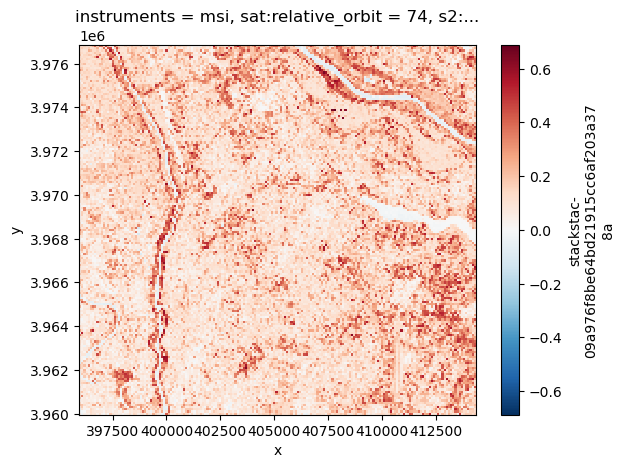

In [14]:
red = data.sel(band="B04").astype("float32")
nir = data.sel(band="B08").astype("float32")

ndvi = (nir - red) / (nir + red)
ndvi_median = ndvi.median(dim="time", skipna=True)

ndvi_median.plot()
